- Add `ConcatConv2D` channel for time.
- Visualize and preprocess other QoIs (max U, max N, max |B|), concatenate to arrival time targets.

- Plot predictions on test set.

- visualize GradCAM mappings!

In [154]:
import sys
import torch
import torch.nn
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.data import random_split
import pandas as pd
import numpy as np
import os
import re
import sys
import logging
import torchvision
import torchvision.transforms as T

In [155]:
args = {
    "niters": 450,
    "lr": 0.001,
    "save": "arr_experiments/",
    "load": None,
    "r": 1991,
    "resize_dims": (16, 64),
    "param_scaling": [1, 1],
    "warm_start": 20376,
    "do_warm_start": False,
    # "loss": "smooth_l1",
    "loss": "mae",
    # "loss": "mse",
    "batch_size": 32,
    "dropout":False
}

In [156]:
import torch.nn as nn

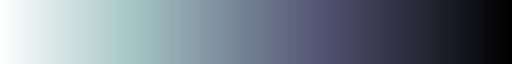

In [157]:
from sunpy.visualization import colormaps as cm

lc3_reg = cm.cmlist['soholasco3']
lc3_reg

lc3 = cm.cmlist['soholasco3'].reversed()
lc3

In [158]:
import time
import datetime
import argparse
from random import SystemRandom

from rich.progress import track
import tqdm

import matplotlib.pyplot as plt

import cnn_utils as cu

In [159]:
from sklearn.model_selection import train_test_split

In [160]:
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer

In [161]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

Filter out runs which arrive very late.

In [163]:
arr_times_data = pd.read_csv("./data_surrogate/UShift_CME3_120runs.csv")
arr_times_data = arr_times_data.dropna()

print(arr_times_data.iloc[5, :])
print(arr_times_data.iloc[9, :])
print(arr_times_data.iloc[10, :])

# arr_times_data.head()
# arr_times_data.index[5]

arr_times_data.drop([arr_times_data.index[5],
                     arr_times_data.index[9],
                     arr_times_data.index[10]], inplace=True)

arr_times_data.head(15)

SIMID          9.0
shift        -36.0
Tshock_sim    88.0
Tshock_obs    52.0
Name: 8, dtype: float64
SIMID         13.0
shift        -34.0
Tshock_sim    86.0
Tshock_obs    52.0
Name: 12, dtype: float64
SIMID         15.0
shift        -37.0
Tshock_sim    89.0
Tshock_obs    52.0
Name: 14, dtype: float64


,SIMID,shift,Tshock_sim,Tshock_obs
0,1,-18.0,70.0,52
2,3,-15.0,67.0,52
3,4,-7.0,59.0,52
4,5,-22.0,74.0,52
6,7,-4.0,56.0,52
9,10,-7.0,59.0,52
10,11,-33.0,85.0,52
11,12,-21.0,73.0,52
15,16,0.0,52.0,52
16,17,-1.0,53.0,52


In [164]:
data_sim_ids = arr_times_data['SIMID'].to_numpy()
data_arr_time = arr_times_data['Tshock_sim'].to_numpy()
data_shifts = arr_times_data['shift'].to_numpy()

In [165]:
# First split sim_ids, and arr_time into train and test.
# Based on this load param file for sims and index that

In [166]:
num_sim = len(data_sim_ids)
print(num_sim)

# train_size = np.int64(num_sim * 0.6)
# valid_size = np.int64(num_sim * 0.2)
# test_size = num_sim - train_size - valid_size
# print(train_size, valid_size, test_size)

train_frac, valid_frac, test_frac = 0.6, 0.15, 0.25

110


In [167]:
generator1 = torch.Generator().manual_seed(2024)
train_valid_test = random_split(data_sim_ids, 
                                [train_frac, valid_frac, test_frac],
                                # [train_size, valid_size, test_size],
                                generator=generator1)


In [168]:
data_sim_ids

array([  1,   3,   4,   5,   7,  10,  11,  12,  16,  17,  18,  19,  20,
        21,  23,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120])

In [169]:
train_idx = np.array(train_valid_test[0].indices)
valid_idx = np.array(train_valid_test[1].indices)
test_idx = np.array(train_valid_test[2].indices)

In [170]:
train_sims = data_sim_ids[train_idx] - 1
val_sims = data_sim_ids[valid_idx] - 1
test_sims = data_sim_ids[test_idx] - 1

In [171]:
train_idx

array([ 22, 105,  30,  74,  51,  10,  76, 106, 103,  31,  87,  84,  61,
        35,  80,  33,  97,  12,   8,  45,  37,  18,  48,   2,   9,   6,
        85,  50,  79,  55, 100,  65,  13,  47,   0,   7,  60,  32,  19,
        90,  98,  92,  44,  95,  29,  23, 107,  17,  78,  94,  99,  36,
        14,  52,   3,  20, 108,  62,  75,  54,  11,  24,  57,   4,  16,
        72,  27])

In [172]:
ntrain = train_idx.shape[0]
nval = valid_idx.shape[0]
ntest = test_idx.shape[0]
ntrain, nval, ntest

(67, 16, 27)

In [173]:
all_idx = np.concatenate((train_idx, valid_idx, test_idx), axis=0)

In [174]:
all_idx.min(), all_idx.max()

(0, 109)

In [175]:
data_arr_time.shape

(110,)

In [176]:
data_arr_time

array([70., 67., 59., 74., 56., 59., 85., 73., 52., 53., 78., 69., 67.,
       55., 61., 54., 59., 74., 71., 67., 51., 73., 56., 63., 51., 77.,
       62., 63., 72., 51., 49., 50., 74., 46., 71., 55., 61., 55., 67.,
       46., 65., 69., 56., 54., 51., 53., 64., 49., 44., 56., 50., 55.,
       47., 54., 73., 46., 43., 53., 66., 44., 38., 45., 54., 46., 46.,
       58., 50., 53., 47., 56., 43., 52., 39., 50., 63., 55., 40., 41.,
       56., 44., 38., 47., 62., 41., 40., 47., 38., 58., 39., 44., 37.,
       45., 49., 42., 39., 47., 35., 42., 33., 40., 40., 41., 36., 40.,
       41., 45., 33., 36., 47., 32.])

In [177]:
from netCDF4 import Dataset
from pathlib import Path

In [178]:
fileID = Dataset("./data_surrogate/CR2192_manuscript_validation_120runs_20240513.nc")
# print(fileID.variables)

# only access sims available in the arrival time dataframe.

UxSim = fileID.variables['UxSim'][:].T.data[:, data_sim_ids - 1]
UySim = fileID.variables['UySim'][:].T.data[:, data_sim_ids - 1]
UzSim = fileID.variables['UzSim'][:].T.data[:, data_sim_ids - 1]

USim = np.sqrt(UxSim**2 + UySim**2 + UzSim**2)

BxSim = fileID.variables['BxSim'][:].T.data[:, data_sim_ids - 1]
BySim = fileID.variables['BySim'][:].T.data[:, data_sim_ids - 1]
BzSim = fileID.variables['BzSim'][:].T.data[:, data_sim_ids - 1]

BSim = np.sqrt(BxSim**2 + BySim**2 + BzSim**2)

NpSim = fileID.variables['NpSim'][:].T.data[:, data_sim_ids - 1]

timeSim = fileID.variables['time'][:].data

# # access attribute
# # startTimeSim = fileID.attributes['startTime']
# for name, variable in fileID.variables.items():
#     for attrname in variable.ncattrs():
#         print(attrname, ':', getattr(variable, attrname))

In [179]:
USim.shape, BSim.shape, NpSim.shape, timeSim.shape

((95, 110), (95, 110), (95, 110), (95,))

In [180]:
# convert timeSim to datetime
from datetime import datetime, timedelta

# add timeSim hours to "2017_07_14T02:55:00"
start_time = datetime.strptime("2017_07_14T02:55:00", "%Y_%m_%dT%H:%M:%S")

timedelta(hours=1)

all_times = [start_time + timedelta(hours=int(hr)) for hr in timeSim]
# all_times

In [181]:
# find time index closest to arr_time
arr_time = datetime.strptime("2017_07_16T16:00:00", "%Y_%m_%dT%H:%M:%S")

arr_time_idx = np.abs(np.array(all_times) - arr_time).argmin()
np.array(all_times)[arr_time_idx]

datetime.datetime(2017, 7, 16, 15, 55)

In [182]:
# use shift data to find the time index for individual sims

shifts_data = arr_times_data['shift'].to_numpy().astype(int)

shifts_data
sim_arr_times_idx = np.array([arr_time_idx - shift for shift in shifts_data])

In [183]:
sim_arr_times_idx.shape

(110,)

In [184]:
# extract USim, BSim, NpSim for each sim at respective arr_time_idx

USim_target = np.array([USim[sim_arr_times_idx[i], i] for i in range(num_sim)])
BSim_target = np.array([BSim[sim_arr_times_idx[i], i] for i in range(num_sim)])
NpSim_target = np.array([NpSim[sim_arr_times_idx[i], i] for i in range(num_sim)])

USim_target.shape, BSim_target.shape, NpSim_target.shape

((110,), (110,), (110,))

(array([ 9., 12., 18., 21., 24., 15.,  5.,  2.,  1.,  3.]),
 array([ 0.53035042,  6.66182223, 12.79329404, 18.92476586, 25.05623767,
        31.18770949, 37.3191813 , 43.45065311, 49.58212493, 55.71359674,
        61.84506855]),
 <BarContainer object of 10 artists>)

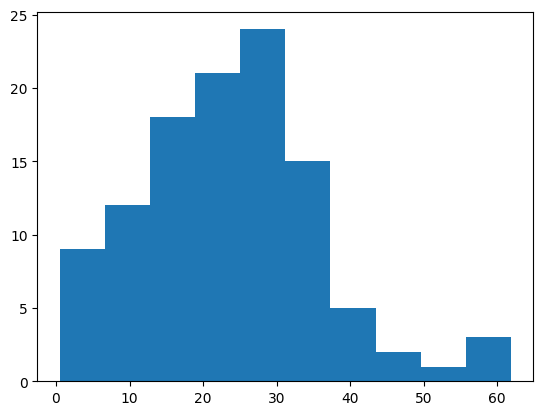

In [185]:
plt.hist(BSim_target)

(array([27., 31., 20., 13., 10.,  3.,  1.,  1.,  2.,  2.]),
 array([  6.47185629,  17.16586826,  27.85988024,  38.55389222,
         49.24790419,  59.94191617,  70.63592814,  81.32994012,
         92.0239521 , 102.71796407, 113.41197605]),
 <BarContainer object of 10 artists>)

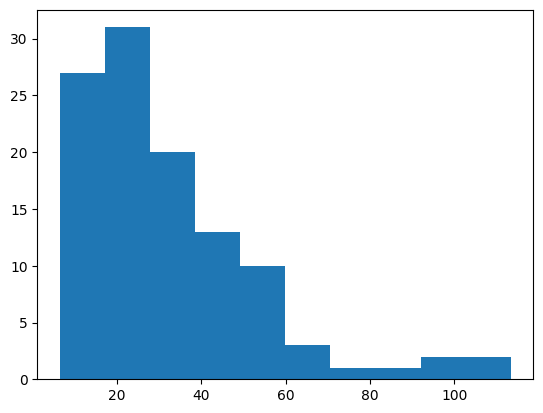

In [186]:
plt.hist(NpSim_target)

In [187]:
# stack data_arr_time, USim_target, BSim_target, NpSim_target into a single array.

target_data = np.stack((data_arr_time, USim_target, BSim_target, NpSim_target), axis=1)

target_data.shape

(110, 4)

In [188]:
all_timesteps = np.linspace(2, 180, 90, dtype=int)
tMinIdx = 50 # hardcoding for now, change later to accomodate variable length sequences
tMaxIdx = len(all_timesteps) - 1
nTimesteps = tMaxIdx - tMinIdx + 1



# scale time appropriately
tt_raw = np.linspace(all_timesteps[tMinIdx], all_timesteps[tMaxIdx], nTimesteps)
tt = np.linspace(0, 1, tMaxIdx - tMinIdx + 1)
tpredict = torch.Tensor(tt).to(device)

nTimesteps, tt_raw

(40,
 array([102., 104., 106., 108., 110., 112., 114., 116., 118., 120., 122.,
        124., 126., 128., 130., 132., 134., 136., 138., 140., 142., 144.,
        146., 148., 150., 152., 154., 156., 158., 160., 162., 164., 166.,
        168., 170., 172., 174., 176., 178., 180.]))

In [189]:
import sklearn
import copy
train_arr_raw = target_data[train_idx, :]
val_arr_raw = target_data[valid_idx, :]
test_arr_raw = target_data[test_idx, :]

print(train_arr_raw.shape, val_arr_raw.shape, test_arr_raw.shape)

# pt = PowerTransformer(method='box-cox')
# pt = sklearn.preprocessing.RobustScaler()
pt = sklearn.preprocessing.MinMaxScaler()
pt.fit(train_arr_raw)

train_arr_pt = pt.transform(train_arr_raw)
val_arr_pt = pt.transform(val_arr_raw)
test_arr_pt = pt.transform(test_arr_raw)

(67, 4) (16, 4) (27, 4)


In [190]:
raw_datafile = np.load("./data_surrogate/CR2192_120runs_C3_ratio_PolarTensor.npy")

In [191]:
raw_datafile.shape

(128, 512, 90, 120)

In [192]:
raw_min, raw_max = raw_datafile.min(), raw_datafile.max()
raw_min, raw_max

(0.799298967364635, 1.5)

In [193]:
train_data_raw = raw_datafile[:, :, :, train_sims]
val_data_raw = raw_datafile[:, :, :, val_sims]
test_data_raw = raw_datafile[:, :, :, test_sims]

In [194]:
resize_dims = args["resize_dims"]

train_data_resized = T.Resize(size=resize_dims,
                                  antialias=True
                                  )(torch.Tensor(train_data_raw.transpose(3, 2, 0, 1)))
    
val_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(val_data_raw.transpose(3, 2, 0, 1)))

test_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(test_data_raw.transpose(3, 2, 0, 1)))

In [195]:
max_train = torch.max(train_data_resized)
min_train = torch.min(train_data_resized)

max_train, min_train

(tensor(1.5000), tensor(0.8940))

In [196]:
train_data = (train_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)
val_data = (val_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)
test_data = (test_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)

In [197]:
train_data.shape, val_data.shape, test_data.shape

(torch.Size([67, 40, 16, 64]),
 torch.Size([16, 40, 16, 64]),
 torch.Size([27, 40, 16, 64]))

In [198]:
train_data.max(), val_data.max(), test_data.max()

(tensor(1.), tensor(1.), tensor(1.))

### Concatenate parameters (optional)

In [199]:
raw_params = pd.read_csv("./data_surrogate/params_2192_120runs.csv")
raw_params = raw_params[["BStrength", "OrientationCme", "ApexHeight", "iHelicity"]]
raw_params

,BStrength,OrientationCme,ApexHeight,iHelicity
0,5.0417,347.475,0.8505,-1
1,5.1250,330.225,0.7196,1
2,6.7917,380.475,0.7482,1
3,5.3750,342.225,0.9123,-1
4,5.2917,322.725,0.8719,1
...,...,...,...,...
115,14.6250,300.225,0.6911,1
116,14.7083,371.475,0.9337,1
117,14.7917,348.225,0.7743,1
118,14.8750,312.975,0.7363,-1


In [200]:
raw_params.agg(['min', 'max'])

,BStrength,OrientationCme,ApexHeight,iHelicity
min,5.0417,294.975,0.6673,-1
max,14.9583,384.225,0.9504,1


In [201]:
raw_params_retained = raw_params.to_numpy()[data_sim_ids - 1, :]
raw_params_retained.shape

(110, 4)

In [202]:
# raw_params_np = raw_params_retained.to_numpy()

In [203]:
param_scaling = [15, 384, 0.95, 1]

In [204]:
raw_params_retained[train_idx, :].shape

(67, 4)

### Train-test split and normalization

Use train_idx, valid_idx and test_idx

In [205]:
train_params_raw = raw_params_retained[train_idx, :] / param_scaling
valid_params_raw = raw_params_retained[valid_idx, :] / param_scaling
test_params_raw = raw_params_retained[test_idx, :] / param_scaling

In [206]:
train_snaps = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
val_snaps = val_data.reshape((val_data.shape[0], val_data.shape[1], -1))
test_snaps = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

# repeat parameter values up to number of timesteps
train_params_ts = np.repeat(train_params_raw.reshape((train_params_raw.shape[0], train_params_raw.shape[1], 1)), nTimesteps, axis=2)
val_params_ts = np.repeat(valid_params_raw.reshape((valid_params_raw.shape[0], valid_params_raw.shape[1], 1)), nTimesteps, axis=2)
test_params_ts = np.repeat(test_params_raw.reshape((test_params_raw.shape[0], test_params_raw.shape[1], 1)), nTimesteps, axis=2)

# concatenate snaps and params
train_all = torch.cat((train_snaps, torch.Tensor(np.transpose(train_params_ts, (0, 2, 1)))), 2)
val_all = torch.cat((val_snaps, torch.Tensor(np.transpose(val_params_ts, (0, 2, 1)))), 2)
test_all = torch.cat((test_snaps, torch.Tensor(np.transpose(test_params_ts, (0, 2, 1)))), 2)

In [207]:
train_snaps.shape, val_snaps.shape

(torch.Size([67, 40, 1024]), torch.Size([16, 40, 1024]))

In [208]:
train_arr_ts = torch.Tensor(train_arr_pt)
val_arr_ts = torch.Tensor(val_arr_pt)
test_arr_ts = torch.Tensor(test_arr_pt)

train_arr_raw_ts = torch.Tensor(train_arr_raw).unsqueeze(1)
val_arr_raw_ts = torch.Tensor(val_arr_raw).unsqueeze(1)
test_arr_raw_ts = torch.Tensor(test_arr_raw).unsqueeze(1)

In [209]:
train_all.shape, val_all.shape, test_all.shape

(torch.Size([67, 40, 1028]),
 torch.Size([16, 40, 1028]),
 torch.Size([27, 40, 1028]))

In [210]:
ntrain, nval, ntest

(67, 16, 27)

In [211]:
train_dataset = []
val_dataset = []
test_dataset = []
for i in range(ntrain):
    for j in range(1, nTimesteps - 1):
        train_dataset.append((train_all[i:(i+1), (j-1):(j+2), :], train_arr_ts[i, :], train_arr_raw_ts[i, :]))

for i in range(nval):
    for j in range(1, nTimesteps - 1):
        val_dataset.append((val_all[i:(i+1), (j-1):(j+2), :], val_arr_ts[i, :], val_arr_raw_ts[i, :]))

for i in range(ntest):
    for j in range(1, nTimesteps - 1):
        test_dataset.append((test_all[i:(i+1), (j-1):(j+2), :], test_arr_ts[i, :], test_arr_raw_ts[i, :]))

In [212]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size = args["batch_size"],
                              shuffle=True, 
                              )

val_dataloader = DataLoader(val_dataset,
                            batch_size = args["batch_size"],
                            shuffle=False,
                            )

test_dataloader = DataLoader(test_dataset,
                             batch_size = len(test_dataset),
                             shuffle=False,
                             )

In [213]:
test_all.shape

torch.Size([27, 40, 1028])

In [214]:
len(train_dataset), len(val_dataset), len(test_dataset)

(2546, 608, 1026)

In [215]:
# blah = train_dataloader.__iter__().__next__()
# blah[0].shape, blah[1].shape, blah[2].shape

In [216]:
def inf_generator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

def get_next_batch(dataloader, device=torch.device("cuda:0")):
    return dataloader.__next__()

In [217]:
class WLCNN_Discrete(torch.nn.Module):
    def __init__(self, n_hidden_1,
                  n_hidden_2):
        super(WLCNN_Discrete, self).__init__()
        in_channels = 3

        self.features = torch.nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ELU(),
            nn.Conv2d(8, 16, kernel_size=5, stride=3, padding=3),
            nn.BatchNorm2d(16),
            nn.ELU(),
            # nn.ELU(),
            # nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=1),
            # nn.BatchNorm2d(64),
            # nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )

        self.regressor = torch.nn.Sequential(
            # nn.Linear(1280, n_hidden_1),
            nn.Linear(1284, n_hidden_1),
            nn.BatchNorm1d(n_hidden_1),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(n_hidden_1, n_hidden_2),
            nn.BatchNorm1d(n_hidden_2),
            nn.Dropout(p=0.5),
            nn.ELU(),
            nn.Linear(n_hidden_2, 4)
        )

    def forward(self, x):
        x_ip = x[:, 0, :, :1024].reshape(-1, 3, 16, 64)
        x_param = x[:, 0, 0, 1024:]
        
        x_ft = self.features(x_ip)
        
        x_ft = torch.flatten(x_ft, 1)

        x_ft_cat = torch.cat((x_ft, x_param), 1)
        # xpred = self.regressor(x_ft)
        xpred = self.regressor(x_ft_cat)

        return xpred

In [218]:
import node_utils as nut
import data_utils as dut
import copy

In [219]:
model = WLCNN_Discrete(n_hidden_1=16,
                       n_hidden_2=8).to(device)
pmodel = nut.count_parameters(model)


print("Total number of parameters for model with concatenation: ", pmodel)

nut.makedirs(os.path.join(os.getcwd(), "arr_logs"))
logdir = os.path.join(os.getcwd(), "arr_logs")

exptdir = os.path.join(os.getcwd(), args["save"])
nut.makedirs(exptdir)

if args["load"] is not None:
    experimentID = args["load"]
    print("Loading experiment")
else:
    if args["do_warm_start"]==True:
        experimentID = args["warm_start"]
        print("Warm starting previous experiment")
    else:
        experimentID = int(SystemRandom().random() * 1e5)
        print("Starting New experiment")

print("Experiment ID: ", experimentID)

ckpt_path = ckpt_path = os.path.join(exptdir, "experiment_" + str(experimentID) + '.ckpt')

print("Checkpoint path: ", ckpt_path)

logger = dut.get_logger(logpath=os.path.join(logdir, "experiment_" + str(experimentID) + '.log'))

logger.info(os.getcwd())
logger.info(model)
logger.info("Number of parameters: {}".format(pmodel))
logger.info(args)
logger.info(ckpt_path)
logger.info(device)

Total number of parameters for model with concatenation:  24268
Starting New experiment
Experiment ID:  77561
Checkpoint path:  /Users/ajivani/Desktop/Research/WLROM/WhiteLight/arr_experiments/experiment_77561.ckpt
/Users/ajivani/Desktop/Research/WLROM/WhiteLight
WLCNN_Discrete(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (regressor): Sequential(
    (0): Linear(in_features=1284, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.5, inplace=

In [220]:
optimizer = optim.Adam(model.parameters(), lr=args["lr"])
if args["loss"] == "smooth_l1":
    criterion = nn.SmoothL1Loss().to(device)
elif args["loss"] == "mae":
    criterion = nn.L1Loss().to(device)
elif args["loss"] == "mse":
    criterion = nn.MSELoss().to(device)

# criterion = InverseBoxCoxLoss(pt)

print(criterion)
early_stopping = nut.EarlyStopping(patience=20,
                                verbose=True,
                                path=ckpt_path)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.6, patience=40)
N_EPOCHS = args["niters"]

num_batches = 1
all_train_loss = []
all_valid_loss = []
ckpt_freq = 10
if args["load"] is None:
    if args["do_warm_start"] == True:
        checkpoint = torch.load(ckpt_path)
        model.load_state_dict(checkpoint['model'])
        start_epoch = checkpoint['epoch']
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        print("Warm Starting Experiment {} from Epoch {}".format(experimentID, start_epoch))
    else:
        start_epoch = 0
        print("Starting a new experiment {} from Epoch {}".format(experimentID, start_epoch))

    # Resume training from specific epoch
    for itr in track(range(start_epoch + 1, num_batches * (args["niters"] + 1)), description="Looping over epochs..."):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        optimizer.zero_grad()

        for i, (raw_img, arr_target_scaled, arr_target) in enumerate(train_dataloader):
            raw_img = raw_img.to(device)
            # arr_target = arr_target.to(device)
            arr_target = arr_target_scaled.to(device)

            # Forward pass
            arr_pred = model(raw_img)

            # Compute Loss
            loss = criterion(arr_pred, arr_target)

            # Backward pass
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for i, (raw_img_val, arr_target_val_scaled, arr_target_val) in enumerate(val_dataloader):
                raw_img_val = raw_img_val.to(device)
                # arr_target_val = arr_target_val.to(device)
                arr_target_val = arr_target_val_scaled.to(device)

                # Forward pass
                arr_pred_val = model(raw_img_val)

                val_loss = criterion(arr_pred_val, arr_target_val)

                valid_loss += val_loss.item()

        train_loss = train_loss / len(train_dataloader)
        valid_loss = valid_loss / len(val_dataloader)

        all_train_loss.append(train_loss)
        all_valid_loss.append(valid_loss)


        message = 'Epoch {:04d}|Val loss {:.6e}|Train loss {:.6e}|LR {:.5f}|'.format(
                        itr//num_batches,
                        valid_loss,
                        train_loss,
                        optimizer.param_groups[0]["lr"])
        
        logger.info(message)
        scheduler.step(valid_loss)

        if itr % ckpt_freq == 0:
            early_stopping(val_loss, all_valid_loss, all_train_loss, model, optimizer, itr, args)

        if early_stopping.early_stop:
            logger.info("Early stopping")
            torch.save({'epoch': itr,
                    'model': model.state_dict(),
                    'optimizer_state': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'all_train_loss': all_train_loss,
                    'all_valid_loss': all_valid_loss,
                    'args': args},
                    os.path.join(args["save"], "experiment_" + str(experimentID) + "_earlystopping.ckpt"))
            break
else:
    # check if early stopped model is available!
    early_stop_filepath = os.path.join(args["save"], "experiment_" + str(experimentID) + "_earlystopping.ckpt")

    if os.path.exists(early_stop_filepath):
        if args["load"] == 56:
            early_stp_ckpt = torch.load(early_stop_filepath)
            model.load_state_dict(early_stp_ckpt)
        else:
            nut.get_ckpt_model(early_stop_filepath, model, optimizer, device)
        print("Loading early stopped model ID {} from {}".format(experimentID, early_stop_filepath))
    else:
        nut.get_ckpt_model(ckpt_path, model, optimizer, device)
        print("Loading existing model ID {} from {}".format(experimentID, ckpt_path))

Output()

L1Loss()
Starting a new experiment 77561 from Epoch 0


Epoch 0001|Val loss 2.804832e-01|Train loss 3.735861e-01|LR 0.00100|

Epoch 0002|Val loss 1.712347e-01|Train loss 2.395945e-01|LR 0.00100|

Epoch 0003|Val loss 1.843657e-01|Train loss 2.021080e-01|LR 0.00100|

Epoch 0004|Val loss 1.546348e-01|Train loss 1.853778e-01|LR 0.00100|

Epoch 0005|Val loss 1.873206e-01|Train loss 1.751190e-01|LR 0.00100|

Epoch 0006|Val loss 1.455224e-01|Train loss 1.661775e-01|LR 0.00100|

Epoch 0007|Val loss 1.375934e-01|Train loss 1.603255e-01|LR 0.00100|

Epoch 0008|Val loss 1.284641e-01|Train loss 1.570361e-01|LR 0.00100|

Epoch 0009|Val loss 1.163111e-01|Train loss 1.470110e-01|LR 0.00100|

Epoch 0010|Val loss 1.148082e-01|Train loss 1.409450e-01|LR 0.00100|

Val loss decreased (inf to 0.15). Model saved

Epoch 0011|Val loss 1.248597e-01|Train loss 1.410151e-01|LR 0.00100|

Epoch 0012|Val loss 1.268598e-01|Train loss 1.418760e-01|LR 0.00100|

Epoch 0013|Val loss 1.253572e-01|Train loss 1.470086e-01|LR 0.00100|

Epoch 0014|Val loss 1.414305e-01|Train loss 1.477572e-01|LR 0.00100|

Epoch 0015|Val loss 1.071595e-01|Train loss 1.449430e-01|LR 0.00100|

Epoch 0016|Val loss 1.252512e-01|Train loss 1.402715e-01|LR 0.00100|

Epoch 0017|Val loss 1.186956e-01|Train loss 1.400345e-01|LR 0.00100|

Epoch 0018|Val loss 1.163666e-01|Train loss 1.408103e-01|LR 0.00100|

Epoch 0019|Val loss 1.230787e-01|Train loss 1.382347e-01|LR 0.00100|

Epoch 0020|Val loss 1.110305e-01|Train loss 1.390634e-01|LR 0.00100|

Val loss decreased (0.11 to 0.13). Model saved

Epoch 0021|Val loss 1.173990e-01|Train loss 1.398194e-01|LR 0.00100|

Epoch 0022|Val loss 1.479160e-01|Train loss 1.394874e-01|LR 0.00100|

Epoch 0023|Val loss 1.152860e-01|Train loss 1.393396e-01|LR 0.00100|

Epoch 0024|Val loss 1.325307e-01|Train loss 1.380100e-01|LR 0.00100|

Epoch 0025|Val loss 1.219042e-01|Train loss 1.382861e-01|LR 0.00100|

Epoch 0026|Val loss 1.252492e-01|Train loss 1.399815e-01|LR 0.00100|

Epoch 0027|Val loss 1.190869e-01|Train loss 1.397112e-01|LR 0.00100|

Epoch 0028|Val loss 1.730558e-01|Train loss 1.366559e-01|LR 0.00100|

Epoch 0029|Val loss 1.311881e-01|Train loss 1.364095e-01|LR 0.00100|

Epoch 0030|Val loss 1.004946e-01|Train loss 1.360145e-01|LR 0.00100|

Val loss decreased (0.11 to 0.10). Model saved

Epoch 0031|Val loss 1.158465e-01|Train loss 1.354819e-01|LR 0.00100|

Epoch 0032|Val loss 1.315973e-01|Train loss 1.345643e-01|LR 0.00100|

Epoch 0033|Val loss 1.169088e-01|Train loss 1.338882e-01|LR 0.00100|

Epoch 0034|Val loss 1.151245e-01|Train loss 1.365179e-01|LR 0.00100|

Epoch 0035|Val loss 1.344424e-01|Train loss 1.408699e-01|LR 0.00100|

Epoch 0036|Val loss 1.176143e-01|Train loss 1.400091e-01|LR 0.00100|

Epoch 0037|Val loss 1.234695e-01|Train loss 1.375372e-01|LR 0.00100|

Epoch 0038|Val loss 1.601846e-01|Train loss 1.380124e-01|LR 0.00100|

Epoch 0039|Val loss 1.328016e-01|Train loss 1.398890e-01|LR 0.00100|

Epoch 0040|Val loss 1.494724e-01|Train loss 1.315107e-01|LR 0.00100|

EarlyStopping counter: 1 out of 20

Epoch 0041|Val loss 1.255306e-01|Train loss 1.343158e-01|LR 0.00100|

Epoch 0042|Val loss 1.224643e-01|Train loss 1.344274e-01|LR 0.00100|

Epoch 0043|Val loss 1.136175e-01|Train loss 1.352719e-01|LR 0.00100|

Epoch 0044|Val loss 1.247623e-01|Train loss 1.376472e-01|LR 0.00100|

Epoch 0045|Val loss 1.220953e-01|Train loss 1.364910e-01|LR 0.00100|

Epoch 0046|Val loss 1.249057e-01|Train loss 1.352246e-01|LR 0.00100|

Epoch 0047|Val loss 1.583547e-01|Train loss 1.350405e-01|LR 0.00100|

Epoch 0048|Val loss 1.547200e-01|Train loss 1.351012e-01|LR 0.00100|

Epoch 0049|Val loss 1.088044e-01|Train loss 1.334910e-01|LR 0.00100|

Epoch 0050|Val loss 1.181506e-01|Train loss 1.345499e-01|LR 0.00100|

EarlyStopping counter: 2 out of 20

Epoch 0051|Val loss 1.091977e-01|Train loss 1.345643e-01|LR 0.00100|

Epoch 0052|Val loss 1.149014e-01|Train loss 1.317227e-01|LR 0.00100|

Epoch 0053|Val loss 1.037444e-01|Train loss 1.337556e-01|LR 0.00100|

Epoch 0054|Val loss 1.137809e-01|Train loss 1.322226e-01|LR 0.00100|

Epoch 0055|Val loss 1.083127e-01|Train loss 1.338205e-01|LR 0.00100|

Epoch 0056|Val loss 1.172600e-01|Train loss 1.339606e-01|LR 0.00100|

Epoch 0057|Val loss 1.471807e-01|Train loss 1.337791e-01|LR 0.00100|

Epoch 0058|Val loss 1.276400e-01|Train loss 1.331338e-01|LR 0.00100|

Epoch 0059|Val loss 1.044794e-01|Train loss 1.305757e-01|LR 0.00100|

Epoch 0060|Val loss 1.185832e-01|Train loss 1.310758e-01|LR 0.00100|

EarlyStopping counter: 3 out of 20

Epoch 0061|Val loss 1.019201e-01|Train loss 1.342775e-01|LR 0.00100|

Epoch 0062|Val loss 1.236051e-01|Train loss 1.306923e-01|LR 0.00100|

Epoch 0063|Val loss 1.055681e-01|Train loss 1.308319e-01|LR 0.00100|

Epoch 0064|Val loss 1.177302e-01|Train loss 1.330942e-01|LR 0.00100|

Epoch 0065|Val loss 1.117677e-01|Train loss 1.327922e-01|LR 0.00100|

Epoch 0066|Val loss 1.056705e-01|Train loss 1.292872e-01|LR 0.00100|

Epoch 0067|Val loss 1.264757e-01|Train loss 1.312429e-01|LR 0.00100|

Epoch 0068|Val loss 1.409848e-01|Train loss 1.323837e-01|LR 0.00100|

Epoch 0069|Val loss 1.314387e-01|Train loss 1.328569e-01|LR 0.00100|

Epoch 0070|Val loss 1.213247e-01|Train loss 1.319714e-01|LR 0.00100|

EarlyStopping counter: 4 out of 20

Epoch 0071|Val loss 1.030642e-01|Train loss 1.321230e-01|LR 0.00100|

Epoch 0072|Val loss 1.253824e-01|Train loss 1.308604e-01|LR 0.00060|

Epoch 0073|Val loss 8.969984e-02|Train loss 1.284217e-01|LR 0.00060|

Epoch 0074|Val loss 1.198497e-01|Train loss 1.252210e-01|LR 0.00060|

Epoch 0075|Val loss 9.510390e-02|Train loss 1.242380e-01|LR 0.00060|

Epoch 0076|Val loss 1.143648e-01|Train loss 1.241650e-01|LR 0.00060|

Epoch 0077|Val loss 1.181224e-01|Train loss 1.236481e-01|LR 0.00060|

Epoch 0078|Val loss 1.140873e-01|Train loss 1.245026e-01|LR 0.00060|

Epoch 0079|Val loss 1.056282e-01|Train loss 1.247023e-01|LR 0.00060|

Epoch 0080|Val loss 1.116199e-01|Train loss 1.266828e-01|LR 0.00060|

EarlyStopping counter: 5 out of 20

Epoch 0081|Val loss 9.609997e-02|Train loss 1.258927e-01|LR 0.00060|

Epoch 0082|Val loss 1.040134e-01|Train loss 1.250876e-01|LR 0.00060|

Epoch 0083|Val loss 9.155792e-02|Train loss 1.229454e-01|LR 0.00060|

Epoch 0084|Val loss 1.117261e-01|Train loss 1.255394e-01|LR 0.00060|

Epoch 0085|Val loss 9.124662e-02|Train loss 1.248009e-01|LR 0.00060|

Epoch 0086|Val loss 1.066206e-01|Train loss 1.245295e-01|LR 0.00060|

Epoch 0087|Val loss 1.008508e-01|Train loss 1.259529e-01|LR 0.00060|

Epoch 0088|Val loss 1.237858e-01|Train loss 1.255798e-01|LR 0.00060|

Epoch 0089|Val loss 1.015183e-01|Train loss 1.276344e-01|LR 0.00060|

Epoch 0090|Val loss 1.205925e-01|Train loss 1.267484e-01|LR 0.00060|

EarlyStopping counter: 6 out of 20

Epoch 0091|Val loss 1.044626e-01|Train loss 1.240116e-01|LR 0.00060|

Epoch 0092|Val loss 1.171296e-01|Train loss 1.232199e-01|LR 0.00060|

Epoch 0093|Val loss 9.415566e-02|Train loss 1.248309e-01|LR 0.00060|

Epoch 0094|Val loss 1.140170e-01|Train loss 1.245834e-01|LR 0.00060|

Epoch 0095|Val loss 9.360516e-02|Train loss 1.232661e-01|LR 0.00060|

Epoch 0096|Val loss 1.086641e-01|Train loss 1.246598e-01|LR 0.00060|

Epoch 0097|Val loss 1.003647e-01|Train loss 1.237750e-01|LR 0.00060|

Epoch 0098|Val loss 1.201321e-01|Train loss 1.229893e-01|LR 0.00060|

Epoch 0099|Val loss 1.032428e-01|Train loss 1.230377e-01|LR 0.00060|

Epoch 0100|Val loss 1.025926e-01|Train loss 1.246452e-01|LR 0.00060|

EarlyStopping counter: 7 out of 20

Epoch 0101|Val loss 1.037489e-01|Train loss 1.226309e-01|LR 0.00060|

Epoch 0102|Val loss 1.008748e-01|Train loss 1.236746e-01|LR 0.00060|

Epoch 0103|Val loss 1.092712e-01|Train loss 1.224770e-01|LR 0.00060|

Epoch 0104|Val loss 9.836921e-02|Train loss 1.237373e-01|LR 0.00060|

Epoch 0105|Val loss 1.008853e-01|Train loss 1.219406e-01|LR 0.00060|

Epoch 0106|Val loss 9.564020e-02|Train loss 1.224116e-01|LR 0.00060|

Epoch 0107|Val loss 9.258859e-02|Train loss 1.196628e-01|LR 0.00060|

Epoch 0108|Val loss 1.107022e-01|Train loss 1.201959e-01|LR 0.00060|

Epoch 0109|Val loss 9.003237e-02|Train loss 1.219168e-01|LR 0.00060|

Epoch 0110|Val loss 1.051229e-01|Train loss 1.223234e-01|LR 0.00060|

EarlyStopping counter: 8 out of 20

Epoch 0111|Val loss 9.216157e-02|Train loss 1.221662e-01|LR 0.00060|

Epoch 0112|Val loss 9.849019e-02|Train loss 1.192574e-01|LR 0.00060|

Epoch 0113|Val loss 9.220486e-02|Train loss 1.200700e-01|LR 0.00060|

Epoch 0114|Val loss 1.081696e-01|Train loss 1.203102e-01|LR 0.00060|

Epoch 0115|Val loss 9.429473e-02|Train loss 1.217018e-01|LR 0.00036|

Epoch 0116|Val loss 9.252348e-02|Train loss 1.164138e-01|LR 0.00036|

Epoch 0117|Val loss 9.090094e-02|Train loss 1.156177e-01|LR 0.00036|

Epoch 0118|Val loss 9.570127e-02|Train loss 1.175526e-01|LR 0.00036|

Epoch 0119|Val loss 9.737735e-02|Train loss 1.159926e-01|LR 0.00036|

Epoch 0120|Val loss 1.001620e-01|Train loss 1.161821e-01|LR 0.00036|

Val loss decreased (0.10 to 0.13). Model saved

Epoch 0121|Val loss 8.820773e-02|Train loss 1.164876e-01|LR 0.00036|

Epoch 0122|Val loss 1.095774e-01|Train loss 1.171530e-01|LR 0.00036|

Epoch 0123|Val loss 9.129402e-02|Train loss 1.181852e-01|LR 0.00036|

Epoch 0124|Val loss 1.027263e-01|Train loss 1.190759e-01|LR 0.00036|

Epoch 0125|Val loss 8.828680e-02|Train loss 1.161191e-01|LR 0.00036|

Epoch 0126|Val loss 9.809297e-02|Train loss 1.156388e-01|LR 0.00036|

Epoch 0127|Val loss 9.177502e-02|Train loss 1.157541e-01|LR 0.00036|

Epoch 0128|Val loss 9.458456e-02|Train loss 1.153908e-01|LR 0.00036|

Epoch 0129|Val loss 9.579853e-02|Train loss 1.166451e-01|LR 0.00036|

Epoch 0130|Val loss 9.554810e-02|Train loss 1.154715e-01|LR 0.00036|

Val loss decreased (0.10 to 0.13). Model saved

Epoch 0131|Val loss 9.838258e-02|Train loss 1.159996e-01|LR 0.00036|

Epoch 0132|Val loss 9.861887e-02|Train loss 1.158262e-01|LR 0.00036|

Epoch 0133|Val loss 1.059970e-01|Train loss 1.161540e-01|LR 0.00036|

Epoch 0134|Val loss 9.732145e-02|Train loss 1.163128e-01|LR 0.00036|

Epoch 0135|Val loss 1.081370e-01|Train loss 1.154270e-01|LR 0.00036|

Epoch 0136|Val loss 1.022382e-01|Train loss 1.154370e-01|LR 0.00036|

Epoch 0137|Val loss 1.023380e-01|Train loss 1.145174e-01|LR 0.00036|

Epoch 0138|Val loss 9.759700e-02|Train loss 1.137420e-01|LR 0.00036|

Epoch 0139|Val loss 9.928580e-02|Train loss 1.157636e-01|LR 0.00036|

Epoch 0140|Val loss 9.718871e-02|Train loss 1.167343e-01|LR 0.00036|

EarlyStopping counter: 1 out of 20

Epoch 0141|Val loss 9.950218e-02|Train loss 1.161569e-01|LR 0.00036|

Epoch 0142|Val loss 9.549905e-02|Train loss 1.163347e-01|LR 0.00036|

Epoch 0143|Val loss 1.009239e-01|Train loss 1.152366e-01|LR 0.00036|

Epoch 0144|Val loss 9.706623e-02|Train loss 1.147823e-01|LR 0.00036|

Epoch 0145|Val loss 1.065842e-01|Train loss 1.138654e-01|LR 0.00036|

Epoch 0146|Val loss 9.075110e-02|Train loss 1.143103e-01|LR 0.00036|

Epoch 0147|Val loss 1.115891e-01|Train loss 1.164438e-01|LR 0.00036|

Epoch 0148|Val loss 9.433428e-02|Train loss 1.159518e-01|LR 0.00036|

Epoch 0149|Val loss 1.059142e-01|Train loss 1.151759e-01|LR 0.00036|

Epoch 0150|Val loss 9.551925e-02|Train loss 1.132059e-01|LR 0.00036|

Val loss decreased (0.10 to 0.12). Model saved

Epoch 0151|Val loss 1.082249e-01|Train loss 1.159976e-01|LR 0.00036|

Epoch 0152|Val loss 9.543649e-02|Train loss 1.164990e-01|LR 0.00036|

Epoch 0153|Val loss 1.065058e-01|Train loss 1.158007e-01|LR 0.00036|

Epoch 0154|Val loss 9.311204e-02|Train loss 1.137354e-01|LR 0.00036|

Epoch 0155|Val loss 1.117569e-01|Train loss 1.149210e-01|LR 0.00036|

Epoch 0156|Val loss 9.498580e-02|Train loss 1.158500e-01|LR 0.00036|

Epoch 0157|Val loss 1.145062e-01|Train loss 1.158258e-01|LR 0.00036|

Epoch 0158|Val loss 9.482774e-02|Train loss 1.161932e-01|LR 0.00036|

Epoch 0159|Val loss 1.042582e-01|Train loss 1.167034e-01|LR 0.00036|

Epoch 0160|Val loss 9.614141e-02|Train loss 1.150658e-01|LR 0.00036|

EarlyStopping counter: 1 out of 20

Epoch 0161|Val loss 1.018969e-01|Train loss 1.150244e-01|LR 0.00036|

Epoch 0162|Val loss 9.472237e-02|Train loss 1.140388e-01|LR 0.00036|

Epoch 0163|Val loss 9.729005e-02|Train loss 1.139268e-01|LR 0.00022|

Epoch 0164|Val loss 9.340279e-02|Train loss 1.120241e-01|LR 0.00022|

Epoch 0165|Val loss 9.620938e-02|Train loss 1.108461e-01|LR 0.00022|

Epoch 0166|Val loss 9.490336e-02|Train loss 1.103208e-01|LR 0.00022|

Epoch 0167|Val loss 1.020209e-01|Train loss 1.118850e-01|LR 0.00022|

Epoch 0168|Val loss 9.594187e-02|Train loss 1.100869e-01|LR 0.00022|

Epoch 0169|Val loss 1.031098e-01|Train loss 1.114311e-01|LR 0.00022|

Epoch 0170|Val loss 9.153972e-02|Train loss 1.117273e-01|LR 0.00022|

Val loss decreased (0.10 to 0.12). Model saved

Epoch 0171|Val loss 1.020823e-01|Train loss 1.095341e-01|LR 0.00022|

Epoch 0172|Val loss 9.461390e-02|Train loss 1.113389e-01|LR 0.00022|

Epoch 0173|Val loss 1.050114e-01|Train loss 1.104726e-01|LR 0.00022|

Epoch 0174|Val loss 9.672716e-02|Train loss 1.118449e-01|LR 0.00022|

Epoch 0175|Val loss 1.004423e-01|Train loss 1.111137e-01|LR 0.00022|

Epoch 0176|Val loss 9.287281e-02|Train loss 1.105328e-01|LR 0.00022|

Epoch 0177|Val loss 1.008578e-01|Train loss 1.100760e-01|LR 0.00022|

Epoch 0178|Val loss 9.236703e-02|Train loss 1.122574e-01|LR 0.00022|

Epoch 0179|Val loss 1.018462e-01|Train loss 1.126913e-01|LR 0.00022|

Epoch 0180|Val loss 9.737332e-02|Train loss 1.114536e-01|LR 0.00022|

EarlyStopping counter: 1 out of 20

Epoch 0181|Val loss 1.028789e-01|Train loss 1.097120e-01|LR 0.00022|

Epoch 0182|Val loss 9.472847e-02|Train loss 1.102942e-01|LR 0.00022|

Epoch 0183|Val loss 1.013495e-01|Train loss 1.118940e-01|LR 0.00022|

Epoch 0184|Val loss 9.312769e-02|Train loss 1.104012e-01|LR 0.00022|

Epoch 0185|Val loss 1.041655e-01|Train loss 1.114281e-01|LR 0.00022|

Epoch 0186|Val loss 9.512713e-02|Train loss 1.105363e-01|LR 0.00022|

Epoch 0187|Val loss 9.806703e-02|Train loss 1.117829e-01|LR 0.00022|

Epoch 0188|Val loss 9.675359e-02|Train loss 1.113077e-01|LR 0.00022|

Epoch 0189|Val loss 1.011663e-01|Train loss 1.101082e-01|LR 0.00022|

Epoch 0190|Val loss 9.485130e-02|Train loss 1.119759e-01|LR 0.00022|

EarlyStopping counter: 2 out of 20

Epoch 0191|Val loss 9.997182e-02|Train loss 1.104347e-01|LR 0.00022|

Epoch 0192|Val loss 9.324879e-02|Train loss 1.112438e-01|LR 0.00022|

Epoch 0193|Val loss 9.862330e-02|Train loss 1.112208e-01|LR 0.00022|

Epoch 0194|Val loss 9.252622e-02|Train loss 1.117919e-01|LR 0.00022|

Epoch 0195|Val loss 9.900640e-02|Train loss 1.099967e-01|LR 0.00022|

Epoch 0196|Val loss 9.432939e-02|Train loss 1.096189e-01|LR 0.00022|

Epoch 0197|Val loss 1.036283e-01|Train loss 1.114016e-01|LR 0.00022|

Epoch 0198|Val loss 1.005295e-01|Train loss 1.104457e-01|LR 0.00022|

Epoch 0199|Val loss 1.082846e-01|Train loss 1.107439e-01|LR 0.00022|

Epoch 0200|Val loss 9.657006e-02|Train loss 1.102703e-01|LR 0.00022|

EarlyStopping counter: 3 out of 20

Epoch 0201|Val loss 1.037068e-01|Train loss 1.103801e-01|LR 0.00022|

Epoch 0202|Val loss 9.091483e-02|Train loss 1.108119e-01|LR 0.00022|

Epoch 0203|Val loss 9.939187e-02|Train loss 1.107591e-01|LR 0.00022|

Epoch 0204|Val loss 9.750670e-02|Train loss 1.104068e-01|LR 0.00013|

Epoch 0205|Val loss 9.554169e-02|Train loss 1.097401e-01|LR 0.00013|

Epoch 0206|Val loss 9.909148e-02|Train loss 1.087770e-01|LR 0.00013|

Epoch 0207|Val loss 1.003444e-01|Train loss 1.083721e-01|LR 0.00013|

Epoch 0208|Val loss 9.681753e-02|Train loss 1.088209e-01|LR 0.00013|

Epoch 0209|Val loss 9.970459e-02|Train loss 1.094592e-01|LR 0.00013|

Epoch 0210|Val loss 1.006174e-01|Train loss 1.082529e-01|LR 0.00013|

EarlyStopping counter: 4 out of 20

Epoch 0211|Val loss 9.741687e-02|Train loss 1.096893e-01|LR 0.00013|

Epoch 0212|Val loss 9.851502e-02|Train loss 1.092601e-01|LR 0.00013|

Epoch 0213|Val loss 1.002651e-01|Train loss 1.094586e-01|LR 0.00013|

Epoch 0214|Val loss 9.809634e-02|Train loss 1.082754e-01|LR 0.00013|

Epoch 0215|Val loss 9.716234e-02|Train loss 1.084564e-01|LR 0.00013|

Epoch 0216|Val loss 1.005885e-01|Train loss 1.079730e-01|LR 0.00013|

Epoch 0217|Val loss 9.775161e-02|Train loss 1.067974e-01|LR 0.00013|

Epoch 0218|Val loss 1.012072e-01|Train loss 1.096762e-01|LR 0.00013|

Epoch 0219|Val loss 9.357084e-02|Train loss 1.088105e-01|LR 0.00013|

Epoch 0220|Val loss 9.812574e-02|Train loss 1.092159e-01|LR 0.00013|

EarlyStopping counter: 5 out of 20

Epoch 0221|Val loss 9.714872e-02|Train loss 1.089782e-01|LR 0.00013|

Epoch 0222|Val loss 9.840575e-02|Train loss 1.095159e-01|LR 0.00013|

Epoch 0223|Val loss 9.601925e-02|Train loss 1.090184e-01|LR 0.00013|

Epoch 0224|Val loss 9.834716e-02|Train loss 1.085134e-01|LR 0.00013|

Epoch 0225|Val loss 1.021871e-01|Train loss 1.066443e-01|LR 0.00013|

Epoch 0226|Val loss 1.008960e-01|Train loss 1.074349e-01|LR 0.00013|

Epoch 0227|Val loss 9.967034e-02|Train loss 1.071812e-01|LR 0.00013|

Epoch 0228|Val loss 1.042974e-01|Train loss 1.078220e-01|LR 0.00013|

Epoch 0229|Val loss 9.342427e-02|Train loss 1.080236e-01|LR 0.00013|

Epoch 0230|Val loss 1.007035e-01|Train loss 1.075330e-01|LR 0.00013|

EarlyStopping counter: 6 out of 20

Epoch 0231|Val loss 1.004017e-01|Train loss 1.071992e-01|LR 0.00013|

Epoch 0232|Val loss 9.968188e-02|Train loss 1.074221e-01|LR 0.00013|

Epoch 0233|Val loss 9.785032e-02|Train loss 1.081829e-01|LR 0.00013|

Epoch 0234|Val loss 9.721777e-02|Train loss 1.080498e-01|LR 0.00013|

Epoch 0235|Val loss 9.840865e-02|Train loss 1.087219e-01|LR 0.00013|

Epoch 0236|Val loss 9.850737e-02|Train loss 1.081480e-01|LR 0.00013|

Epoch 0237|Val loss 9.546092e-02|Train loss 1.078411e-01|LR 0.00013|

Epoch 0238|Val loss 1.015457e-01|Train loss 1.077430e-01|LR 0.00013|

Epoch 0239|Val loss 9.599351e-02|Train loss 1.082587e-01|LR 0.00013|

Epoch 0240|Val loss 1.008350e-01|Train loss 1.082946e-01|LR 0.00013|

EarlyStopping counter: 7 out of 20

Epoch 0241|Val loss 9.585553e-02|Train loss 1.095420e-01|LR 0.00013|

Epoch 0242|Val loss 1.033259e-01|Train loss 1.086619e-01|LR 0.00013|

Epoch 0243|Val loss 9.603925e-02|Train loss 1.072831e-01|LR 0.00013|

Epoch 0244|Val loss 1.026526e-01|Train loss 1.059358e-01|LR 0.00013|

Epoch 0245|Val loss 1.004079e-01|Train loss 1.058049e-01|LR 0.00008|

Epoch 0246|Val loss 9.642818e-02|Train loss 1.083254e-01|LR 0.00008|

Epoch 0247|Val loss 9.913909e-02|Train loss 1.081327e-01|LR 0.00008|

Epoch 0248|Val loss 1.005788e-01|Train loss 1.081964e-01|LR 0.00008|

Epoch 0249|Val loss 9.913895e-02|Train loss 1.066391e-01|LR 0.00008|

Epoch 0250|Val loss 9.928769e-02|Train loss 1.073117e-01|LR 0.00008|

EarlyStopping counter: 8 out of 20

Epoch 0251|Val loss 9.860792e-02|Train loss 1.058218e-01|LR 0.00008|

Epoch 0252|Val loss 1.010296e-01|Train loss 1.063615e-01|LR 0.00008|

Epoch 0253|Val loss 1.002549e-01|Train loss 1.068949e-01|LR 0.00008|

Epoch 0254|Val loss 9.660969e-02|Train loss 1.070300e-01|LR 0.00008|

Epoch 0255|Val loss 9.848535e-02|Train loss 1.065702e-01|LR 0.00008|

Epoch 0256|Val loss 9.732926e-02|Train loss 1.064949e-01|LR 0.00008|

Epoch 0257|Val loss 9.981929e-02|Train loss 1.069876e-01|LR 0.00008|

Epoch 0258|Val loss 9.685683e-02|Train loss 1.062761e-01|LR 0.00008|

Epoch 0259|Val loss 9.931215e-02|Train loss 1.077258e-01|LR 0.00008|

Epoch 0260|Val loss 9.884831e-02|Train loss 1.066305e-01|LR 0.00008|

EarlyStopping counter: 9 out of 20

Epoch 0261|Val loss 1.000896e-01|Train loss 1.064611e-01|LR 0.00008|

Epoch 0262|Val loss 9.798701e-02|Train loss 1.077656e-01|LR 0.00008|

Epoch 0263|Val loss 1.016900e-01|Train loss 1.067208e-01|LR 0.00008|

Epoch 0264|Val loss 9.983340e-02|Train loss 1.077828e-01|LR 0.00008|

Epoch 0265|Val loss 1.019378e-01|Train loss 1.070912e-01|LR 0.00008|

Epoch 0266|Val loss 1.002832e-01|Train loss 1.073521e-01|LR 0.00008|

Epoch 0267|Val loss 9.849436e-02|Train loss 1.061833e-01|LR 0.00008|

Epoch 0268|Val loss 9.766414e-02|Train loss 1.067057e-01|LR 0.00008|

Epoch 0269|Val loss 9.892336e-02|Train loss 1.053865e-01|LR 0.00008|

Epoch 0270|Val loss 1.010411e-01|Train loss 1.065813e-01|LR 0.00008|

EarlyStopping counter: 10 out of 20

Epoch 0271|Val loss 9.946058e-02|Train loss 1.058187e-01|LR 0.00008|

Epoch 0272|Val loss 9.861118e-02|Train loss 1.071600e-01|LR 0.00008|

Epoch 0273|Val loss 9.896636e-02|Train loss 1.065176e-01|LR 0.00008|

Epoch 0274|Val loss 1.003220e-01|Train loss 1.069404e-01|LR 0.00008|

Epoch 0275|Val loss 9.896460e-02|Train loss 1.071627e-01|LR 0.00008|

Epoch 0276|Val loss 9.967950e-02|Train loss 1.073710e-01|LR 0.00008|

Epoch 0277|Val loss 9.867960e-02|Train loss 1.070334e-01|LR 0.00008|

Epoch 0278|Val loss 9.910608e-02|Train loss 1.059402e-01|LR 0.00008|

Epoch 0279|Val loss 1.002214e-01|Train loss 1.058787e-01|LR 0.00008|

Epoch 0280|Val loss 9.843484e-02|Train loss 1.047114e-01|LR 0.00008|

EarlyStopping counter: 11 out of 20

Epoch 0281|Val loss 9.978601e-02|Train loss 1.056880e-01|LR 0.00008|

Epoch 0282|Val loss 1.015827e-01|Train loss 1.055563e-01|LR 0.00008|

Epoch 0283|Val loss 1.013385e-01|Train loss 1.059127e-01|LR 0.00008|

Epoch 0284|Val loss 1.013858e-01|Train loss 1.067483e-01|LR 0.00008|

Epoch 0285|Val loss 9.824411e-02|Train loss 1.083477e-01|LR 0.00008|

Epoch 0286|Val loss 1.007875e-01|Train loss 1.054969e-01|LR 0.00005|

Epoch 0287|Val loss 9.779193e-02|Train loss 1.066463e-01|LR 0.00005|

Epoch 0288|Val loss 9.817589e-02|Train loss 1.047871e-01|LR 0.00005|

Epoch 0289|Val loss 9.998410e-02|Train loss 1.056539e-01|LR 0.00005|

Epoch 0290|Val loss 9.967572e-02|Train loss 1.059967e-01|LR 0.00005|

EarlyStopping counter: 12 out of 20

Epoch 0291|Val loss 9.982962e-02|Train loss 1.054070e-01|LR 0.00005|

Epoch 0292|Val loss 1.006941e-01|Train loss 1.064963e-01|LR 0.00005|

Epoch 0293|Val loss 1.021918e-01|Train loss 1.068334e-01|LR 0.00005|

Epoch 0294|Val loss 1.042993e-01|Train loss 1.065245e-01|LR 0.00005|

Epoch 0295|Val loss 9.955380e-02|Train loss 1.053606e-01|LR 0.00005|

Epoch 0296|Val loss 9.932097e-02|Train loss 1.050916e-01|LR 0.00005|

Epoch 0297|Val loss 9.910231e-02|Train loss 1.056814e-01|LR 0.00005|

Epoch 0298|Val loss 9.830766e-02|Train loss 1.054846e-01|LR 0.00005|

Epoch 0299|Val loss 9.943051e-02|Train loss 1.065501e-01|LR 0.00005|

Epoch 0300|Val loss 9.945809e-02|Train loss 1.047378e-01|LR 0.00005|

EarlyStopping counter: 13 out of 20

Epoch 0301|Val loss 9.973146e-02|Train loss 1.061440e-01|LR 0.00005|

Epoch 0302|Val loss 9.956971e-02|Train loss 1.038783e-01|LR 0.00005|

Epoch 0303|Val loss 1.019859e-01|Train loss 1.044916e-01|LR 0.00005|

Epoch 0304|Val loss 1.013949e-01|Train loss 1.060529e-01|LR 0.00005|

Epoch 0305|Val loss 1.009696e-01|Train loss 1.052622e-01|LR 0.00005|

Epoch 0306|Val loss 9.955240e-02|Train loss 1.046259e-01|LR 0.00005|

Epoch 0307|Val loss 1.009104e-01|Train loss 1.055394e-01|LR 0.00005|

Epoch 0308|Val loss 1.009612e-01|Train loss 1.062238e-01|LR 0.00005|

Epoch 0309|Val loss 9.957742e-02|Train loss 1.049297e-01|LR 0.00005|

Epoch 0310|Val loss 1.001242e-01|Train loss 1.045778e-01|LR 0.00005|

EarlyStopping counter: 14 out of 20

Epoch 0311|Val loss 1.007264e-01|Train loss 1.067024e-01|LR 0.00005|

Epoch 0312|Val loss 1.024774e-01|Train loss 1.046378e-01|LR 0.00005|

Epoch 0313|Val loss 1.021463e-01|Train loss 1.056118e-01|LR 0.00005|

Epoch 0314|Val loss 1.028334e-01|Train loss 1.044633e-01|LR 0.00005|

Epoch 0315|Val loss 9.970450e-02|Train loss 1.050803e-01|LR 0.00005|

Epoch 0316|Val loss 1.038234e-01|Train loss 1.065460e-01|LR 0.00005|

Epoch 0317|Val loss 1.014733e-01|Train loss 1.049831e-01|LR 0.00005|

Epoch 0318|Val loss 1.005348e-01|Train loss 1.062930e-01|LR 0.00005|

Epoch 0319|Val loss 9.822879e-02|Train loss 1.059879e-01|LR 0.00005|

Epoch 0320|Val loss 1.004826e-01|Train loss 1.046600e-01|LR 0.00005|

EarlyStopping counter: 15 out of 20

Epoch 0321|Val loss 1.017782e-01|Train loss 1.048004e-01|LR 0.00005|

Epoch 0322|Val loss 9.825688e-02|Train loss 1.053518e-01|LR 0.00005|

Epoch 0323|Val loss 9.825693e-02|Train loss 1.062075e-01|LR 0.00005|

Epoch 0324|Val loss 1.009094e-01|Train loss 1.052776e-01|LR 0.00005|

Epoch 0325|Val loss 9.925897e-02|Train loss 1.055743e-01|LR 0.00005|

Epoch 0326|Val loss 1.039713e-01|Train loss 1.054929e-01|LR 0.00005|

Epoch 0327|Val loss 1.014896e-01|Train loss 1.047757e-01|LR 0.00003|

Epoch 0328|Val loss 1.025451e-01|Train loss 1.069968e-01|LR 0.00003|

Epoch 0329|Val loss 1.010079e-01|Train loss 1.048069e-01|LR 0.00003|

Epoch 0330|Val loss 1.024621e-01|Train loss 1.047277e-01|LR 0.00003|

EarlyStopping counter: 16 out of 20

Epoch 0331|Val loss 9.963192e-02|Train loss 1.047784e-01|LR 0.00003|

Epoch 0332|Val loss 9.994804e-02|Train loss 1.035387e-01|LR 0.00003|

Epoch 0333|Val loss 1.019912e-01|Train loss 1.038728e-01|LR 0.00003|

Epoch 0334|Val loss 1.017220e-01|Train loss 1.052341e-01|LR 0.00003|

Epoch 0335|Val loss 9.946275e-02|Train loss 1.050980e-01|LR 0.00003|

Epoch 0336|Val loss 1.031640e-01|Train loss 1.048867e-01|LR 0.00003|

Epoch 0337|Val loss 1.017824e-01|Train loss 1.058275e-01|LR 0.00003|

Epoch 0338|Val loss 1.013157e-01|Train loss 1.040602e-01|LR 0.00003|

Epoch 0339|Val loss 1.005997e-01|Train loss 1.054031e-01|LR 0.00003|

Epoch 0340|Val loss 9.832188e-02|Train loss 1.045780e-01|LR 0.00003|

EarlyStopping counter: 17 out of 20

Epoch 0341|Val loss 1.012731e-01|Train loss 1.051455e-01|LR 0.00003|

Epoch 0342|Val loss 1.000450e-01|Train loss 1.044147e-01|LR 0.00003|

Epoch 0343|Val loss 1.009298e-01|Train loss 1.060028e-01|LR 0.00003|

Epoch 0344|Val loss 1.010976e-01|Train loss 1.044333e-01|LR 0.00003|

Epoch 0345|Val loss 1.009740e-01|Train loss 1.046264e-01|LR 0.00003|

Epoch 0346|Val loss 9.946312e-02|Train loss 1.032730e-01|LR 0.00003|

Epoch 0347|Val loss 1.010327e-01|Train loss 1.036980e-01|LR 0.00003|

Epoch 0348|Val loss 1.010579e-01|Train loss 1.055555e-01|LR 0.00003|

Epoch 0349|Val loss 1.035277e-01|Train loss 1.051646e-01|LR 0.00003|

Epoch 0350|Val loss 1.039328e-01|Train loss 1.055483e-01|LR 0.00003|

EarlyStopping counter: 18 out of 20

Epoch 0351|Val loss 1.008767e-01|Train loss 1.066716e-01|LR 0.00003|

Epoch 0352|Val loss 1.002771e-01|Train loss 1.033441e-01|LR 0.00003|

Epoch 0353|Val loss 1.043205e-01|Train loss 1.039771e-01|LR 0.00003|

Epoch 0354|Val loss 1.003198e-01|Train loss 1.046202e-01|LR 0.00003|

Epoch 0355|Val loss 1.023085e-01|Train loss 1.044126e-01|LR 0.00003|

Epoch 0356|Val loss 1.012441e-01|Train loss 1.048447e-01|LR 0.00003|

Epoch 0357|Val loss 1.006491e-01|Train loss 1.057531e-01|LR 0.00003|

Epoch 0358|Val loss 1.005160e-01|Train loss 1.050532e-01|LR 0.00003|

Epoch 0359|Val loss 1.029504e-01|Train loss 1.048546e-01|LR 0.00003|

Epoch 0360|Val loss 1.044821e-01|Train loss 1.043912e-01|LR 0.00003|

EarlyStopping counter: 19 out of 20

Epoch 0361|Val loss 1.013179e-01|Train loss 1.041733e-01|LR 0.00003|

Epoch 0362|Val loss 1.020797e-01|Train loss 1.037281e-01|LR 0.00003|

Epoch 0363|Val loss 1.014091e-01|Train loss 1.047136e-01|LR 0.00003|

Epoch 0364|Val loss 1.016525e-01|Train loss 1.069301e-01|LR 0.00003|

Epoch 0365|Val loss 1.005283e-01|Train loss 1.044634e-01|LR 0.00003|

Epoch 0366|Val loss 1.009958e-01|Train loss 1.045439e-01|LR 0.00003|

Epoch 0367|Val loss 1.004987e-01|Train loss 1.034951e-01|LR 0.00003|

Epoch 0368|Val loss 1.015626e-01|Train loss 1.054763e-01|LR 0.00002|

Epoch 0369|Val loss 1.003640e-01|Train loss 1.052524e-01|LR 0.00002|

Epoch 0370|Val loss 9.988944e-02|Train loss 1.012374e-01|LR 0.00002|

EarlyStopping counter: 20 out of 20

Early stopping

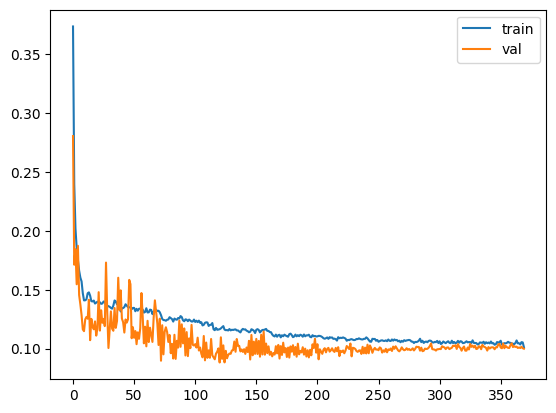

In [223]:
if args["load"] is None: # can remove this loop condition for future experiments since early stopping will also save all_train_loss and all_valid_loss quantities henceforth (Sep 24)
    plt.plot(all_train_loss, label="train")
    plt.plot(all_valid_loss, label="val")
    plt.legend()

In [224]:
train_data_eval = DataLoader(train_dataset, 
        batch_size = len(train_dataset),
        shuffle=False, 
        )

train_eval_batch = get_next_batch(inf_generator(train_data_eval))

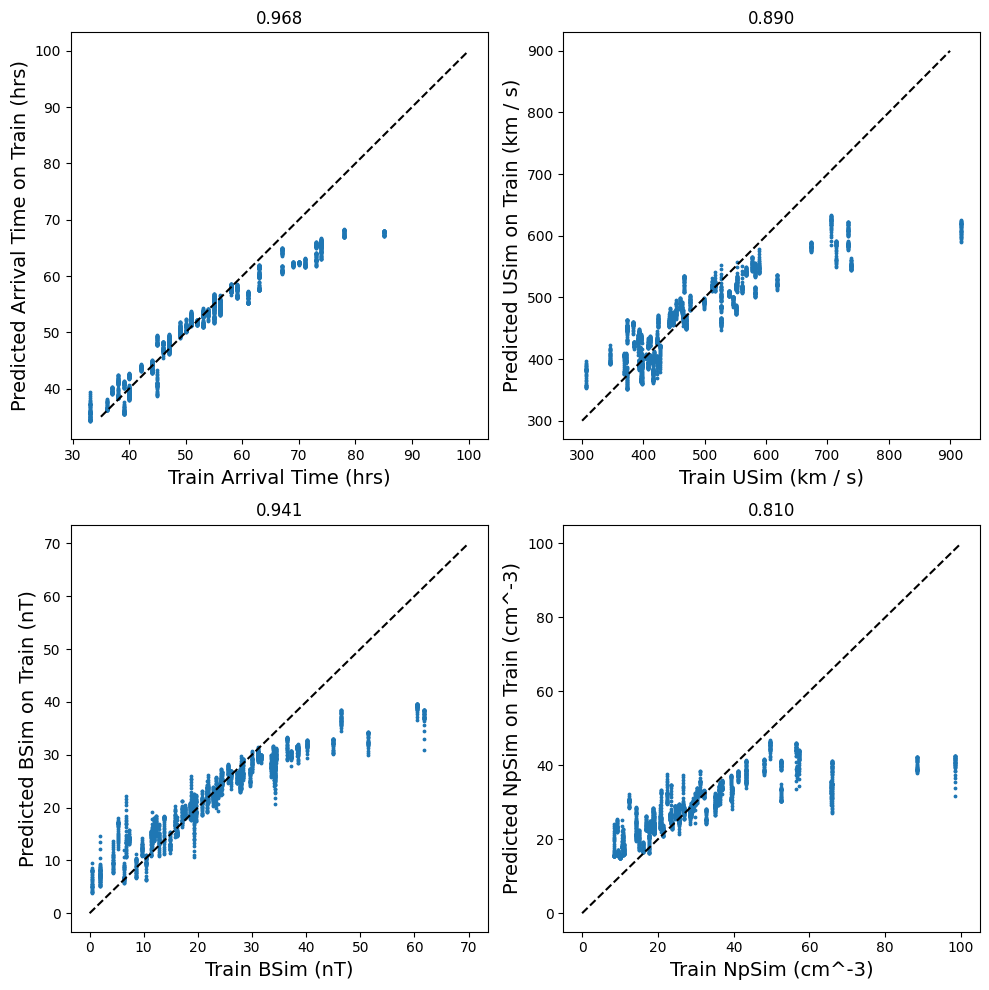

In [225]:
model.eval()
with torch.no_grad():
    train_preds_scaled = model(train_eval_batch[0]).cpu().numpy()

train_preds_unscaled = pt.inverse_transform(train_preds_scaled)
train_targets_all = train_eval_batch[2].squeeze(1).cpu().numpy()

train_preds_unscaled.shape, train_targets_all.shape

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].scatter(train_targets_all[:, 0], train_preds_unscaled[:, 0], s=3)
axs[0, 0].plot(np.linspace(35, 100, 40), np.linspace(35, 100, 40), '--', color='black')
axs[0, 0].set_xlabel("Train Arrival Time (hrs)", fontsize=14)
axs[0, 0].set_ylabel("Predicted Arrival Time on Train (hrs)", fontsize=14)
axs[0, 0].set_title("{:.3f}".format(np.corrcoef(train_targets_all[:, 0], train_preds_unscaled[:, 0])[0, 1]))

axs[0, 1].scatter(train_targets_all[:, 1], train_preds_unscaled[:, 1], s=3)
axs[0, 1].plot(np.linspace(300, 900, 40), np.linspace(300, 900, 40), '--', color='black')
axs[0, 1].set_xlabel("Train USim (km / s)", fontsize=14)
axs[0, 1].set_ylabel("Predicted USim on Train (km / s)", fontsize=14)
axs[0, 1].set_title("{:.3f}".format(np.corrcoef(train_targets_all[:, 1], train_preds_unscaled[:, 1])[0, 1]))

axs[1, 0].scatter(train_targets_all[:, 2], train_preds_unscaled[:, 2], s=3)
axs[1, 0].plot(np.linspace(0, 70, 40), np.linspace(0, 70, 40), '--', color='black')
axs[1, 0].set_xlabel("Train BSim (nT)", fontsize=14)
axs[1, 0].set_ylabel("Predicted BSim on Train (nT)", fontsize=14)
axs[1, 0].set_title("{:.3f}".format(np.corrcoef(train_targets_all[:, 2], train_preds_unscaled[:, 2])[0, 1]))

axs[1, 1].scatter(train_targets_all[:, 3], train_preds_unscaled[:, 3], s=3)
axs[1, 1].plot(np.linspace(0, 100, 40), np.linspace(0, 100, 40), '--', color='black')
axs[1, 1].set_xlabel("Train NpSim (cm^-3)", fontsize=14)
axs[1, 1].set_ylabel("Predicted NpSim on Train (cm^-3)", fontsize=14)
axs[1, 1].set_title("{:.3f}".format(np.corrcoef(train_targets_all[:, 3], train_preds_unscaled[:, 3])[0, 1]))

plt.tight_layout()

(1026, 4) (1026, 4)


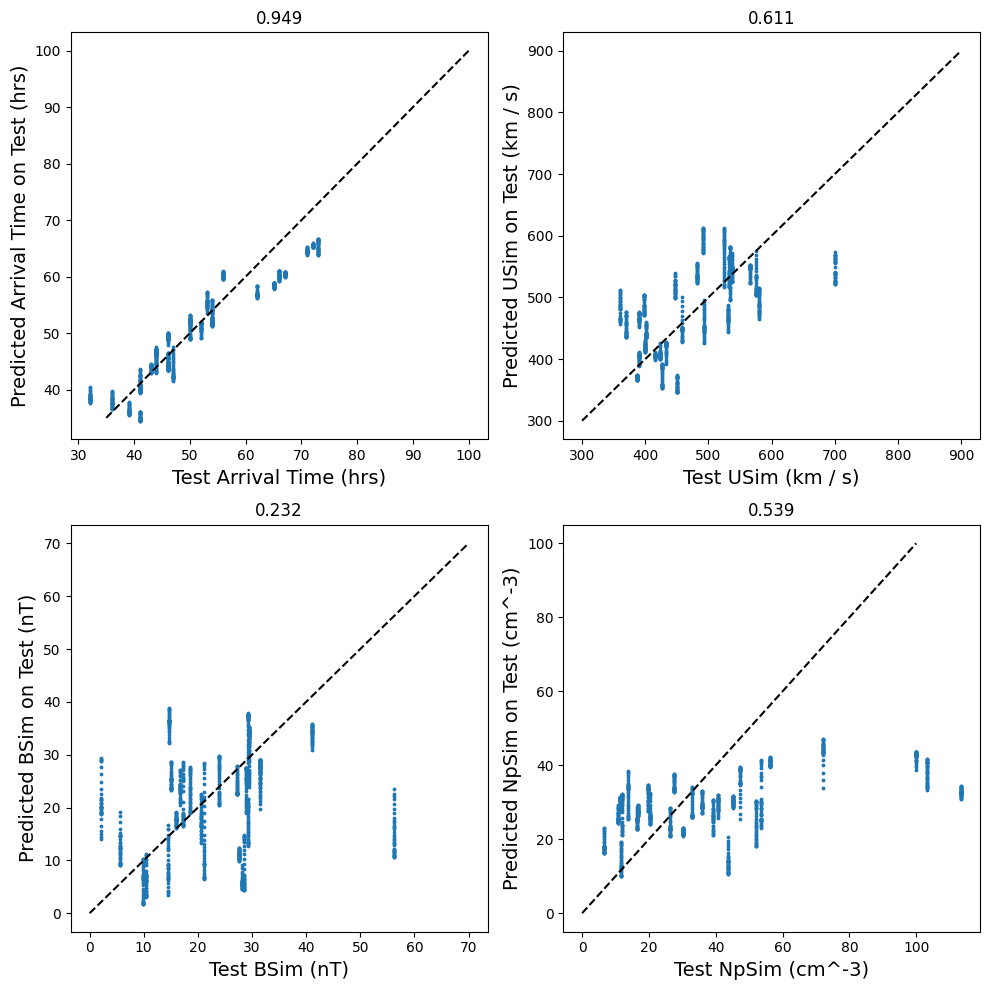

In [227]:
test_data_all = get_next_batch(inf_generator(test_dataloader))
# true_test_arrs = pt.inverse_transform(test_data_all[1].cpu().numpy())
true_test_arrs = test_data_all[2].squeeze(1).cpu().numpy()
model.eval()
with torch.no_grad():
    test_preds = model(test_data_all[0].to(device)).cpu().numpy()

test_preds_unscaled = pt.inverse_transform(test_preds)

print(test_preds_unscaled.shape, true_test_arrs.shape)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].scatter(true_test_arrs[:, 0], test_preds_unscaled[:, 0], s=3)
axs[0, 0].plot(np.linspace(35, 100, 40), np.linspace(35, 100, 40), '--', color='black')
axs[0, 0].set_xlabel("Test Arrival Time (hrs)", fontsize=14)
axs[0, 0].set_ylabel("Predicted Arrival Time on Test (hrs)", fontsize=14)
axs[0, 0].set_title("{:.3f}".format(np.corrcoef(true_test_arrs[:, 0], test_preds_unscaled[:, 0])[0, 1]))

axs[0, 1].scatter(true_test_arrs[:, 1], test_preds_unscaled[:, 1], s=3)
axs[0, 1].plot(np.linspace(300, 900, 40), np.linspace(300, 900, 40), '--', color='black')
axs[0, 1].set_xlabel("Test USim (km / s)", fontsize=14)
axs[0, 1].set_ylabel("Predicted USim on Test (km / s)", fontsize=14)
axs[0, 1].set_title("{:.3f}".format(np.corrcoef(true_test_arrs[:, 1], test_preds_unscaled[:, 1])[0, 1]))

axs[1, 0].scatter(true_test_arrs[:, 2], test_preds_unscaled[:, 2], s=3)
axs[1, 0].plot(np.linspace(0, 70, 40), np.linspace(0, 70, 40), '--', color='black')
axs[1, 0].set_xlabel("Test BSim (nT)", fontsize=14)
axs[1, 0].set_ylabel("Predicted BSim on Test (nT)", fontsize=14)
axs[1, 0].set_title("{:.3f}".format(np.corrcoef(true_test_arrs[:, 2], test_preds_unscaled[:, 2])[0, 1]))

axs[1, 1].scatter(true_test_arrs[:, 3], test_preds_unscaled[:, 3], s=3)
axs[1, 1].plot(np.linspace(0, 100, 40), np.linspace(0, 100, 40), '--', color='black')
axs[1, 1].set_xlabel("Test NpSim (cm^-3)", fontsize=14)
axs[1, 1].set_ylabel("Predicted NpSim on Test (cm^-3)", fontsize=14)
axs[1, 1].set_title("{:.3f}".format(np.corrcoef(true_test_arrs[:, 3], test_preds_unscaled[:, 3])[0, 1]))

plt.tight_layout()